In [6]:
using Random, GMRF

include("src/dataGen.jl");
include("src/cavi.jl");
include("src/mcmc.jl");
include("src/plotting.jl");

Taille de la grille (à ne pas modifier)

In [2]:
M₁ = 3;
M₂ = 3;
M = M₁ * M₂;

- Génération de la grille cible
- Création des données artificielles

In [3]:
Random.seed!(300);
Fmu = iGMRF(M₁, M₂, 1, 10);
Fphi = iGMRF(M₁, M₂, 1, 100);
Fxi = iGMRF(M₁, M₂, 1, 100000);
gridTarget = generateTargetGrid(Fmu, Fphi, Fxi);
gridTarget[:, :, 1] = gridTarget[:, :, 1] .+ 10.0;
gridTarget[:, :, 2] = gridTarget[:, :, 2] .+ 1.0;
gridTarget[:, :, 3] = gridTarget[:, :, 3] .+ .3;
nobs = 100;
data = generateData(gridTarget, nobs);

Réglages de CAVI

In [4]:
nEpoch = 10;
epochSize = 10;

initialValues = Dict(
    :μ => zeros(M),
    :ϕ => zeros(M),
    :ξ => zeros(M),
);

spatialScheme = Dict(
    :M => M,
    :Fmu => Fmu,
    :Fphi => Fphi,
    :Fxi => Fxi,
    :data => data,
);

In [7]:
res = runCAVI(nEpoch, epochSize, initialValues, spatialScheme)

KeyError: KeyError: key :M not found

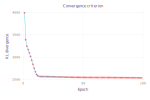

In [7]:
plotConvergenceCriterion(res.MCKL)

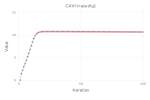

In [8]:
plotTraceCAVI(muMeanTrace[1, :], "μ1")

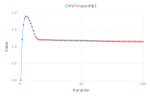

In [9]:
plotTraceCAVI(phiMeanTrace[1, :], "ϕ1")

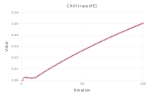

In [10]:
plotTraceCAVI(xiMeanTrace[1, :], "ξ1")

In [11]:
gridTarget

3×3×3 Array{Float64, 3}:
[:, :, 1] =
 10.3547   10.3817    9.99082
  9.86991   9.8917   10.0787
 10.0797    9.66416   9.68869

[:, :, 2] =
 1.02426   0.971222  1.16817
 0.92435   0.924401  1.13091
 0.930856  0.921579  1.00425

[:, :, 3] =
 0.299329  0.299976  0.298913
 0.299674  0.298036  0.297938
 0.302127  0.303741  0.300266

In [12]:
reshape(muMeanTrace[:, end], (3, 3))'

3×3 adjoint(::Matrix{Float64}) with eltype Float64:
 10.6808  10.549   10.1833
 10.5665  10.5293  10.319
 10.5431  10.497   10.2904

In [13]:
reshape(phiMeanTrace[:, end], (3, 3))'

3×3 adjoint(::Matrix{Float64}) with eltype Float64:
 1.14147  1.10656  1.12762
 1.14475  1.11073  1.13267
 1.08206  1.11157  1.14163

In [14]:
reshape(xiMeanTrace[:, end], (3, 3))'

3×3 adjoint(::Matrix{Float64}) with eltype Float64:
 0.0504578  0.0505185  0.0507809
 0.0508597  0.0507403  0.0510037
 0.0508621  0.0510637  0.0511751

In [23]:
datastructure = Dict(
    :Y => data,
    :Fmu => Fmu,
    :Fphi => Fphi,
    :Fxi => Fxi,
);

niter = 10000;

initialvalues = Dict(
    :μ => zeros(M),
    :ϕ => zeros(M),
    :ξ => fill(.2, M),
);

stepsize = Dict(
    :μ => .8,
    :ϕ => .25,
    :ξ => .01,
);

In [24]:
include("src/mcmc.jl")

chain = mcmc(datastructure, niter, initialvalues, stepsize);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [25]:
changerate(chain)

             Change Rate
          μ1       0.260
          μ2       0.225
          μ3       0.230
          μ4       0.213
          μ5       0.202
          μ6       0.218
          μ7       0.240
          μ8       0.224
          μ9       0.243
          ϕ1       0.268
          ϕ2       0.244
          ϕ3       0.258
          ϕ4       0.241
          ϕ5       0.213
          ϕ6       0.236
          ϕ7       0.265
          ϕ8       0.251
          ϕ9       0.271
          ξ1       0.269
          ξ2       0.222
          ξ3       0.261
          ξ4       0.220
          ξ5       0.195
          ξ6       0.226
          ξ7       0.260
          ξ8       0.232
          ξ9       0.269
Multivariate       0.982



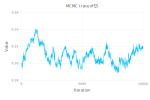

In [26]:
plotTraceMCMC(chain, "ξ5")